In [1]:
%matplotlib inline
import cv2
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt

# Análise multiresolução

Vimos até o momento técnicas para a análise de imagens onde a janela de processamento é fixa, e pequena:

- Análise apenas de valor de pixel: ajuste de contraste, equalização de histograma, segmentação por limiar
- Filtragem linear e invariante ao deslocamento: convolução com *kernels* projetados para 
    - Remoção de ruido
    - Identificação de bordas
    - Filtragem inversa e filtro de Wiener
- Filtros morfológicos

Porém em cenas reais os objetos de interesse podem aparecer com tamanhos diferentes, onde uma janela de processamento de tamanho fixo pode não ser adequada para analisar a presença do objeto. Por exemplo: em uma cena real, o tamanho aparente dos objetos muda com a distância destes para a câmera.

Como resolver esse dilema? Este é o objeto de estudo da área de processamento de imagens e visão computacional conhecida como *análise multirresolução*.

## Decimação e amostragem

*Decimação* é o processo de diminuição do número de pixels de uma imagem através da sub-amostragem desta. Podemos, por exemplo, reduzir o tamanho de uma imagem mantendo apenas cada segundo pixel. 



Vamos fazer um exemplo. Primeiro, vamos construir uma imagem de teste com quatro seções verticais. Cada seção será formada de colunas brancas e pretas, com espessuras de $1$, $2$, $4$ e $8$ pixels:

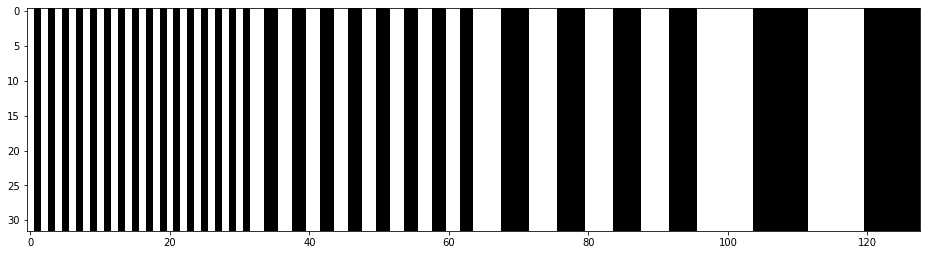

In [2]:
img_test = np.zeros((32, 128))
for s in range(4):
    for j in range(s*32, (s+1)*32, 2**(s + 1)):
        img_test[:, j:j + 2**s] = 1.0
        

plt.figure(figsize=(16, 16))
plt.imshow(img_test, cmap='gray')

Vamos agora sub-amostrar esta imagem mantendo apenas cada segundo pixel:

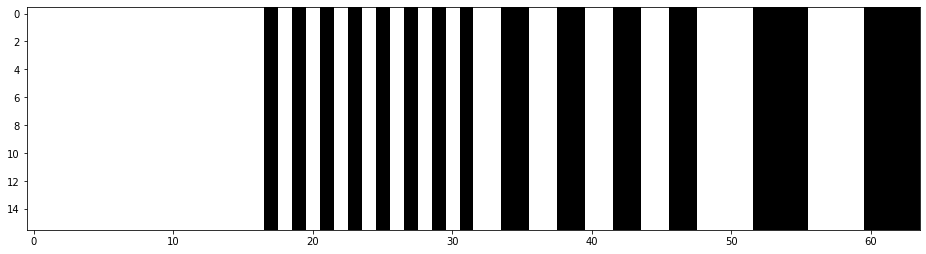

In [3]:
img_test_downsampled = img_test[::2, ::2]
plt.figure(figsize=(16, 16))
plt.imshow(img_test_downsampled, cmap='gray')

O que aconteceu? A primeira seção tinha conteúdo de frequência muito alta. Consequentemente, o processo de amostragem exibiu o fenômeno de *aliasing*.

Melhor seria primeiro filtrar o documento com um filtro passa-baixas, e depois sub-amostrar. 

Como filtro passa-baixas, vamos usar um *filtro Gaussiano* pequeno:

$$
h[i,j] = \frac{1}{256}\left[
\begin{matrix}
1 &  4 &  6 &  4 & 1 \\
4 & 16 & 24 & 16 & 4 \\
6 & 24 & (36) & 24 & 6 \\
4 & 16 & 24 & 16 & 4 \\
1 &  4 &  6 &  4 & 1 \\
\end{matrix}
\right]
$$

In [4]:
kernel = np.array([[1, 4, 6, 4, 1]])
kernel = kernel.transpose().dot(kernel)
kernel = kernel / kernel.sum()

In [5]:
kernel

array([[0.00390625, 0.015625  , 0.0234375 , 0.015625  , 0.00390625],
       [0.015625  , 0.0625    , 0.09375   , 0.0625    , 0.015625  ],
       [0.0234375 , 0.09375   , 0.140625  , 0.09375   , 0.0234375 ],
       [0.015625  , 0.0625    , 0.09375   , 0.0625    , 0.015625  ],
       [0.00390625, 0.015625  , 0.0234375 , 0.015625  , 0.00390625]])

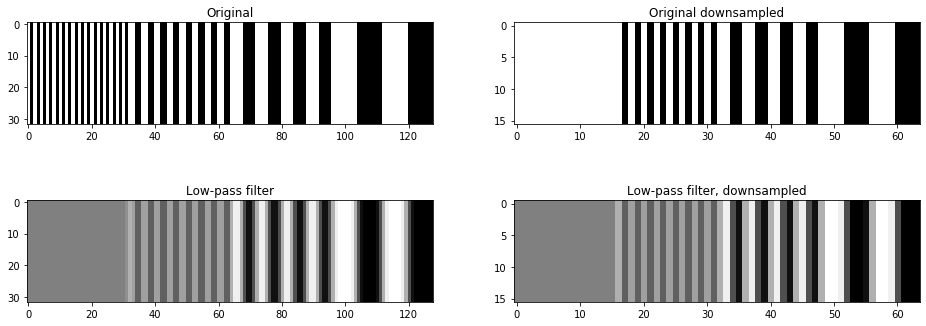

In [6]:
img_lpf = cv2.filter2D(img_test, -1, kernel)
img_lpf_downsampled = img_lpf[::2, ::2]


plt.figure(figsize=(16, 6))

plt.subplot(2, 2, 1)
plt.imshow(img_test, cmap='gray')
plt.title('Original')

plt.subplot(2, 2, 2)
plt.imshow(img_test_downsampled, cmap='gray')
plt.title('Original downsampled')

plt.subplot(2, 2, 3)
plt.imshow(img_lpf, cmap='gray')
plt.title('Low-pass filter')

plt.subplot(2, 2, 4)
plt.imshow(img_lpf_downsampled, cmap='gray')
plt.title('Low-pass filter, downsampled')

plt.show()

# Pirâmide gaussiana

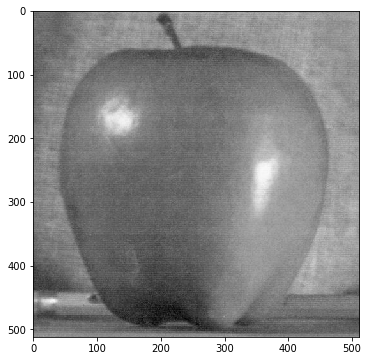

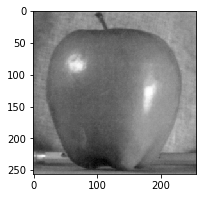

In [7]:
img = cv2.cvtColor(cv2.imread('apple.jpg'), cv2.COLOR_BGR2GRAY) /255.0
img_down = cv2.pyrDown(img)

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.figure(figsize=(3,3))
plt.imshow(img_down, cmap='gray')

In [8]:
img.shape

(512, 512)

**Atividade:** Faça uma função que recebe uma imagem ``img`` e um número de níveis ``L``, e constroi a pirâmide gaussiana desta imagem. Você pode supor que a imagem tem número de linhas e de colunas que são potências de 2, e que são maiores que $2^{L}$.

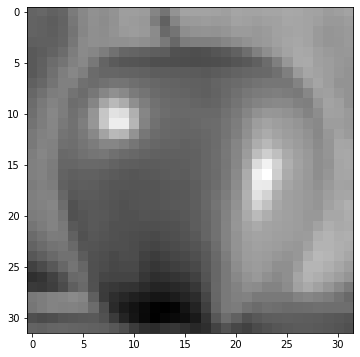

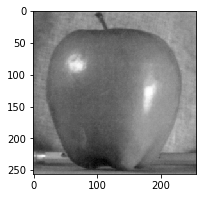

In [19]:
def pira_gauss(img,l):
    for i in range(l):
        img = cv2.pyrDown(img)
        
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap='gray')
    plt.figure(figsize=(3,3))
    plt.imshow(img_down, cmap='gray')
    
img = cv2.cvtColor(cv2.imread('apple.jpg'), cv2.COLOR_BGR2GRAY) /255.0
pira_gauss(img,4)
    

# Pirâmide laplaciana

Text(0.5, 1.0, 'Resíduo')

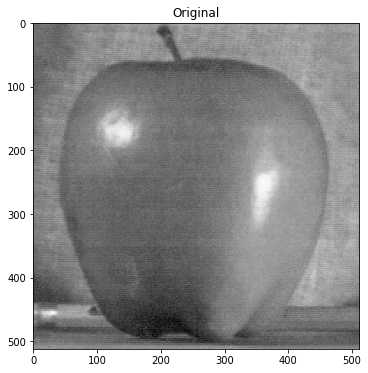

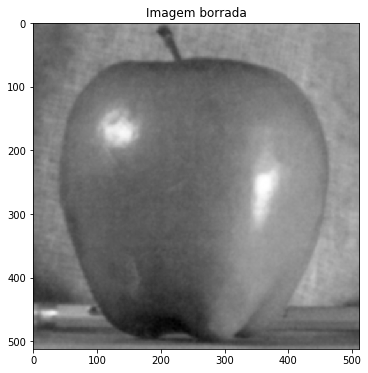

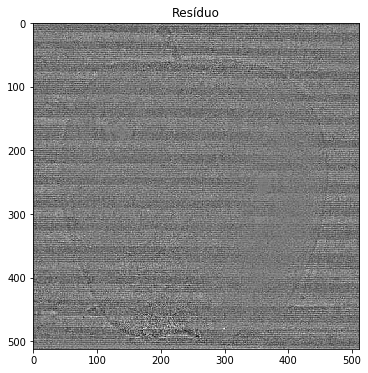

In [20]:
img_blur = cv2.pyrUp(img_down)
img_lapla = img - img_blur

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.figure(figsize=(6,6))
plt.imshow(img_blur, cmap='gray')
plt.title('Imagem borrada')
plt.figure(figsize=(6,6))
plt.imshow(img_lapla, cmap='gray')
plt.title('Resíduo')

**Atividade**: Faça uma função que recebe uma imagem ``img`` e um número de níveis ``L`` e retorna a pirâmide laplaciana desta imagem. Você pode supor que a imagem tem número de linhas e de colunas que são potências de 2, e que são maiores que $2^{L}$.

Dica: use a função da atividade anterior para construir uma pirâmide gaussiana, e a partir desta construa uma pirâmide laplaciana.

Text(0.5, 1.0, 'Resíduo')

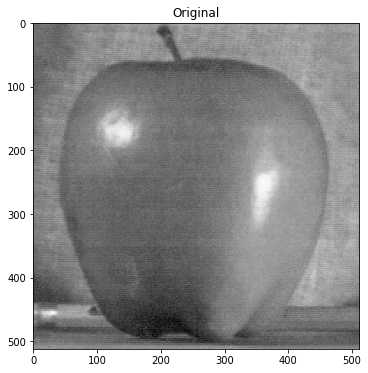

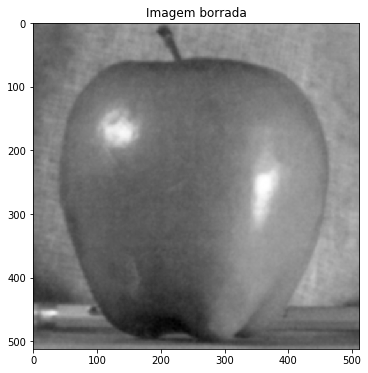

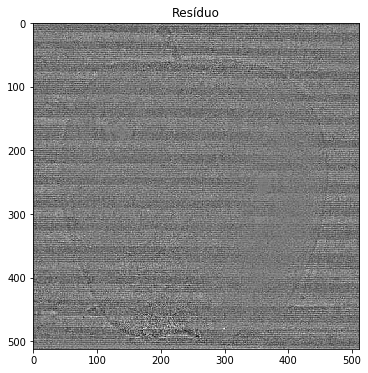

In [34]:
img_blur = cv2.pyrUp(img_down)
img_lapla = img - img_blur

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.figure(figsize=(6,6))
plt.imshow(img_blur, cmap='gray')
plt.title('Imagem borrada')
plt.figure(figsize=(6,6))
plt.imshow(img_lapla, cmap='gray')
plt.title('Resíduo')

**Atividade:** Faça uma função que recebe uma pirâmide laplaciana e retorna a imagem reconstruída.

# Blending

(Baseado no tutorial de piramide do OpenCV)

Vamos tentar unir duas imagens diferentes: metade de uma com metade da outra.

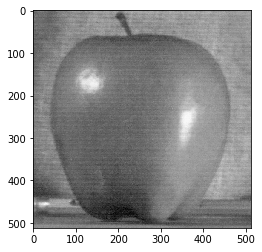

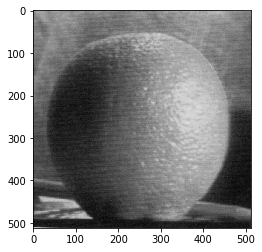

In [10]:
img_A = cv2.cvtColor(cv2.imread('apple.jpg'), cv2.COLOR_BGR2GRAY)
img_B = cv2.cvtColor(cv2.imread('orange.jpg'), cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(img_A, cmap='gray')
plt.figure()
plt.imshow(img_B, cmap='gray')

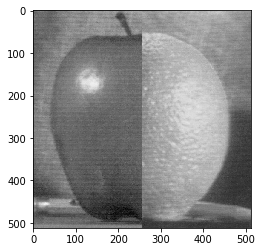

In [11]:
def fusion(img_A, img_B):
    rows, cols = img_A.shape
    return np.hstack((img_A[:, :(cols//2)], img_B[:, (cols//2):]))

img_AB = fusion(img_A, img_B)

plt.figure()
plt.imshow(img_AB, cmap='gray')

Não ficou muito bom. Vamos usar pirâmides laplacianas para fazer um *blending* melhor.

**Atividade**

- Calcule a pirâmide laplaciana de cada uma das imagens

- Faça a fusão das duas pirâmides: junte cada nível da pirâmide de img_A com o nível correspondente da pirâmide de img_B

- Reconstrua a imagem

# Compressão

**Atividade**

- Calcule a pirâmide laplaciana de uma imagem

- Em cada nível resíduo da pirâmide, zere os coeficientes mais "fraquinhos":

    - Determine o valor de corte como sendo um percentil (à sua escolha) dos valores absolutos de pixel. Use ``np.percentile()``
    
- Reconstrua a imagem

Teste seu programa para vários valores de percentil.